# Simple pyPamtra2 example

Note that Fortran output cannot be seen from a jupyter notebook. For debugging Fortran modules, run this notebook from the ipython terminal with '%run notebookname.pynb'

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pn



import pyPamtra2


try:
    %matplotlib inline
except:
    pass



We can have an abritrary number of helper dimensions

In [40]:
additionalDims = OrderedDict()
additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
# additionalDims['hair_color'] = ['red','brown','black']
additionalDims['lat'] = np.arange(70,80)
# additionalDims['lon'] = np.arange(170,180,2)

Create the pyPamtra2 object

In [41]:
pam2 = pyPamtra2.pyPamtra2(
    hydrometeors=['liquidHydros','iceHydros','snowHydros'], # list of names 
    nPeaks = 1, #for which moments are estimated
    nHydroBins=99, 
    nFFT=512,
    additionalDims = additionalDims,
    frequencies = [35]
)


fallVelocityRelation


modify settings

In [42]:
pam2.settings

{'fallVelocityRelation': 'khvorostyanov01_spheres',
 'general': {'verbosity': 0},
 'hydrometeorProperties': {'iceHydros': {},
  'liquidHydros': {},
  'snowHydros': {}},
 'radarProperties': {'35': {'fwhrBeamwidthDeg': 0.31,
   'integrationTime': 1.4,
   'k2': 0.92,
   'maxV': 7.885,
   'minV': -7.885,
   'nAve': 150,
   'pNoise1000': -32.23,
   'smoothSpectrum': True}},
 'radarSimulator': {'aliasingNyquistInterv': 1, 'randomSeed': 0}}

In [43]:
pam2.settings['general']['verbosity'] = 10
pam2.settings['radarSimulator']['randomSeed'] = 5
pam2.settings['radarSimulator']['aliasingNyquistInterv'] = 1
pam2.settings['radarProperties']['35']['nAve'] = 25



 it's a modified dict, so you cannot add keys on your own (or by accident)

In [44]:
# pam2.settings['general']['test'] = 10

Start with the atmospheric data, everything is stored in a .data xarray Dataset. In addition, there is a ._tmp object for intermediate data.

In [45]:
pam2.data.eddyDissipationRate.values[:] = 1e-4
pam2.data.horizontalWind.values[:] = 10
pam2.data.verticalWind.values[:] = 0
pam2.data.temperature.values[:] = 300
pam2.data.pressure.values[:] = 10000
pam2.data.height.values[:] = 1000



add the liquid hydrometeor description. monodisperse distribution (at least almost, we still need Dmin and Dmax)

In [46]:

pam2.addHydrometeorProperties(
    0, #hydrometeor index or name
    [1e-5,2e-5], # Dmin and DMax
    10**7, #N(D)
    psdNormalized = False, #PSD normalized by bins?
    hydroType='liquid'
    )



the same for ice. Here the PSD is estmated by the function pyPamtra2.sizeDistributions.exponential, the parameters are provided by psdFuncArgs (could be arrays, too!)

In [47]:
pam2.addHydrometeorProperties(
    'snowHydros',#hydrometeor index or name
    [1e-5,6e-4],# Dmin and DMax
    pyPamtra2.sizeDistributions.exponential, #this is the function for the psd
    hydroType='snow',
    psdFuncArgs = [100,400], # with these arguments, corresponding to N0 and lambda
    psdNormalized = True,
    hydrometeorProperties = {
        'massSizeA_snow' : 0.0121, #mass size relation (Brown and Freancis) 
        'massSizeB_snow' : 1.9,
        'areaSizeA_snow' : 0.02, #area size relation (random)
        'areaSizeB_snow' : 1.4,
        'maxDensity_snow' : 971.,
    }
)


In [48]:
pam2.addHydrometeorProperties(
    'iceHydros',#hydrometeor index or name
    [1e-5,6e-5],# Dmin and DMax
    pyPamtra2.sizeDistributions.exponential, #this is the function for the psd
    hydroType='ice',
    psdFuncArgs = [100,400], # with these arguments, corresponding to N0 and lambda
    psdNormalized = True,
)



now we have all variables together, let's run the model. Note that we do all processing steps for all columns together. This might be too much for large model fields. In this case the user has to add a loop. Routines which will provide a subset of teh data set will be added later.

In [49]:
pam2.settings

{'fallVelocityRelation': 'khvorostyanov01_spheres',
 'general': {'verbosity': 10},
 'hydrometeorProperties': {'iceHydros': {'refractiveIndexModel': 'Matzler_2006',
   'type': 'ice'},
  'liquidHydros': {'refractiveIndexModel': 'Ellison', 'type': 'liquid'},
  'snowHydros': {'areaSizeA_snow': 0.02,
   'areaSizeB_snow': 1.4,
   'massSizeA_snow': 0.0121,
   'massSizeB_snow': 1.9,
   'maxDensity_snow': 971.0,
   'refractiveIndexMix_snow': 'Bruggeman',
   'refractiveIndexModel': 'Matzler_2006',
   'type': 'snow'}},
 'radarProperties': {'35': {'fwhrBeamwidthDeg': 0.31,
   'integrationTime': 1.4,
   'k2': 0.92,
   'maxV': 7.885,
   'minV': -7.885,
   'nAve': 25,
   'pNoise1000': -32.23,
   'smoothSpectrum': True}},
 'radarSimulator': {'aliasingNyquistInterv': 1, 'randomSeed': 5}}

estimate the refractive index 

In [50]:
pam2.getRefractiveIndex()

decorating eps 2 1 [0, 2] [0]
in 2 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 0 (1, 10, 1, 1) (10, 1) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)


estimate the broadening of the radar Doppler spectrum

In [51]:
pam2.getSpectralBroadening()

decorating calcSpectralBraodening 0 0 [0, 1, 2] [0]
in 0 (1, 10, 1) (10,) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
in 2 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10,) (1, 10, 1) (1, 10, 1)


scattering properties

In [52]:
pam2.getScattering(method='Rayleigh')

decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)
decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)
decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)


In [53]:
pam2.getScattering(method='Rayleigh')

decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)
decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)
decorating rayleigh 0 1 [0, 1] [0]
in 0 (1, 10, 1, 99) (10, 99) (1, 10, 1) False
in 1 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 99) (1, 10, 1, 99) (1, 10, 1)


estimate path integrated attenuation (alibi function! returns 0!) 

In [54]:
pam2.getPIA()



now estimate the radar Doppler spectrum

(There is a numerical issue caused by the convolution of turbulence: You can test it by increasing N0 of the snow PSD)

In [55]:
pam2.getRadarSpectrum()



decorating simulateRadarSpectrum 0 2 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] [0]
in 0 (1, 10, 1, 3, 99) (10, 3, 99) (1, 10, 1) False
in 1 (1, 10, 1, 3, 99) (10, 3, 99) (1, 10, 1) False
in 2 (1, 10, 1, 3, 99) (10, 3, 99) (1, 10, 1) False
in 3 (1, 10, 1, 3, 99) (10, 3, 99) (1, 10, 1) False
in 4 (1, 10, 1, 3, 99) (10, 3, 99) (1, 10, 1) False
in 5 (1, 10, 1) (10,) (1, 10, 1) False
in 6 (1, 10, 1) (10,) (1, 10, 1) False
in 7 (1, 10, 1) (10,) (1, 10, 1) False
in 8 (1, 10, 1) (10,) (1, 10, 1) False
in 9 (1, 10, 1) (10,) (1, 10, 1) False
in 10 (1, 10, 1) (10,) (1, 10, 1) False
out 0 (10, 512) (1, 10, 1, 512) (1, 10, 1)


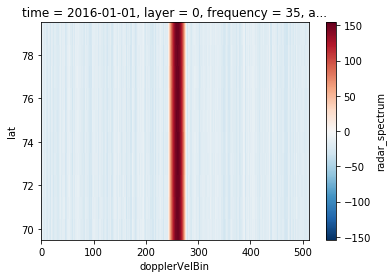

In [56]:


(10*np.log10(pam2.results.radar_spectrum)).plot()



In [39]:
pam2.results.radar_spectrum

<xarray.DataArray 'radar_spectrum' (time: 1, layer: 1, frequency: 1, activePolarisation: 1, dopplerVelBin: 512)>
array([[[[[ 0.015788, ...,  0.011695]]]]])
Coordinates:
  * time                (time) datetime64[ns] 2016-01-01
  * layer               (layer) int64 0
  * frequency           (frequency) int64 35
  * activePolarisation  (activePolarisation) <U2 'NN'
  * dopplerVelBin       (dopplerVelBin) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
Attributes:
    unit:     mm6/m3

Estimate the moments of the radar Doppler spectrum. All results are stored in a .results xarray Dataset

In [57]:
pam2.getRadarMoments()